In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import TensorDataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [22]:
data  = pd.read_csv('heart_disease_dataset.csv', sep = ';')
df = data.copy()
df

,age,sex,chest_pain_type,resting_blood_pressure,cholesterol,fasting_blood_sugar,rest_ecg,max_heart_rate_achieved,exercise_induced_angina,st_depression,st_slope,num_major_vessels,thalassemia,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   age                      303 non-null    int64  
 1   sex                      303 non-null    int64  
 2   chest_pain_type          303 non-null    int64  
 3   resting_blood_pressure   303 non-null    int64  
 4   cholesterol              303 non-null    int64  
 5   fasting_blood_sugar      303 non-null    int64  
 6   rest_ecg                 303 non-null    int64  
 7   max_heart_rate_achieved  303 non-null    int64  
 8   exercise_induced_angina  303 non-null    int64  
 9   st_depression            303 non-null    float64
 10  st_slope                 303 non-null    int64  
 11  num_major_vessels        303 non-null    int64  
 12  thalassemia              303 non-null    int64  
 13  target                   303 non-null    int64  
dtypes: float64(1), int64(13)
m

<Axes: >

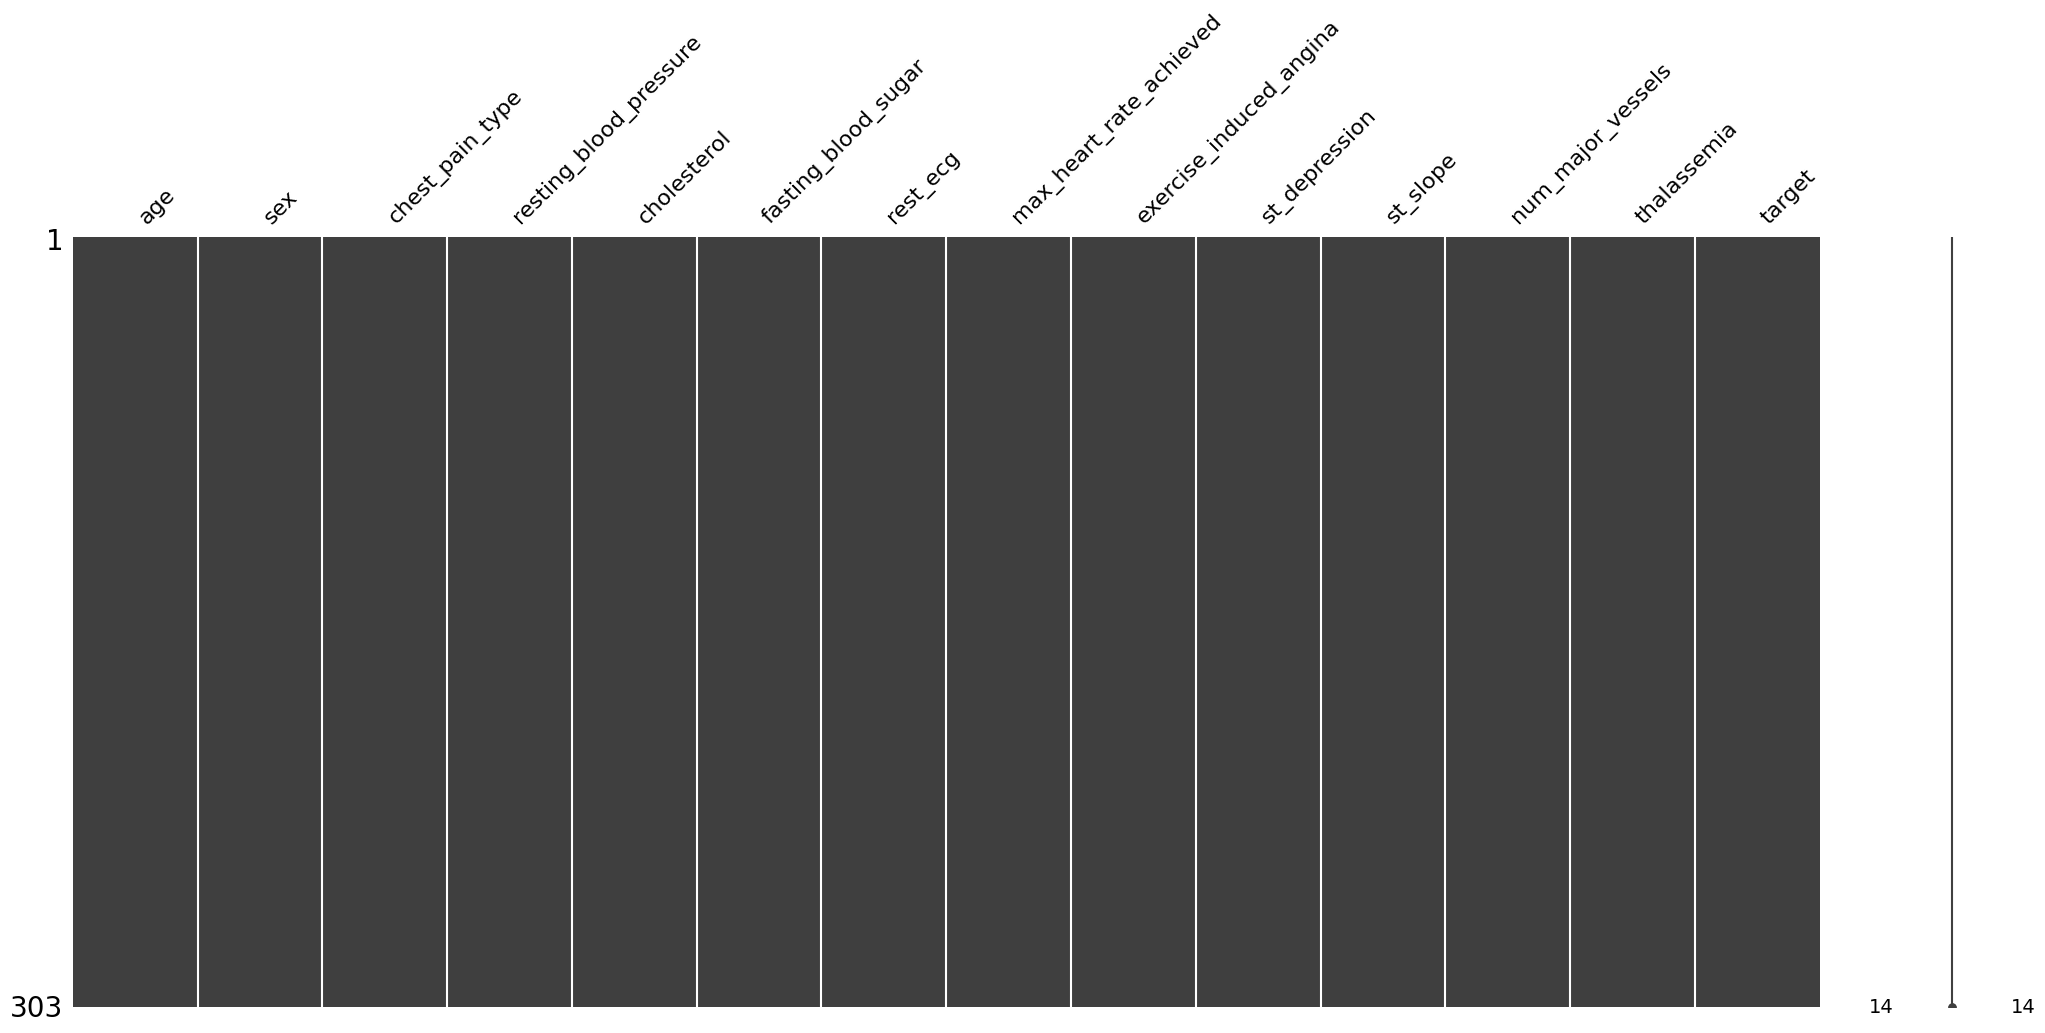

In [6]:
df.isnull().sum()
msno.matrix(df)

target
1    165
0    138
Name: count, dtype: int64


<Axes: xlabel='target', ylabel='count'>

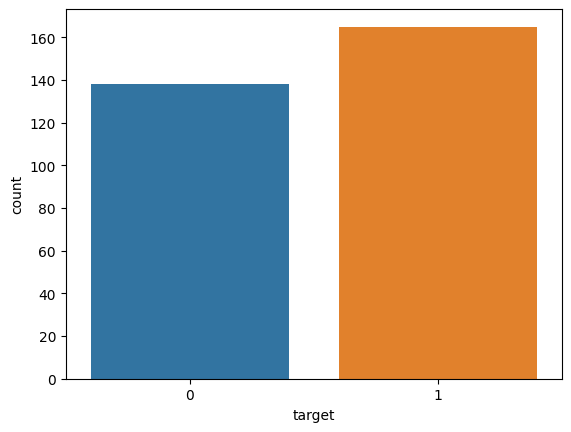

In [7]:
print(df.target.value_counts())
sns.countplot(x = df.target)

In [23]:
scale = RobustScaler()

In [24]:
x = df.drop('target', axis = 1)
y = df.target.values.reshape(-1,1)
x = scale.fit_transform(x)

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.2, stratify = y)

In [25]:
y_train.dtype

dtype('int64')

In [16]:
x_train = torch.from_numpy(x_train).float()
x_test = torch.from_numpy(x_test).float()
y_train = torch.from_numpy(y_train).float()  
y_test = torch.from_numpy(y_test).float()   

In [17]:
train_dataset = TensorDataset(x_train, y_train)
test_dataset = TensorDataset(x_test, y_test)

In [19]:
train_dataset

In [58]:
train_loader = DataLoader(train_dataset, batch_size = 3, shuffle = True)
test_loader = DataLoader(test_dataset, shuffle = True)

Modeling

In [62]:
class Detect (nn.Module):
    def __init__(self):
        super(Detect, self).__init__()
        self.fc1 = nn.Linear(x.shape[1],6)
        self.fc2 = nn.Linear(6, 4)
        self.out = nn.Linear(4, 1)
    def forward (self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.out(x)
        return x

In [63]:
model = Detect()

In [81]:
num_epochs = 9
lr_rate = 0.00001
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr = lr_rate)

In [65]:
def binary_acc (y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum / y_test.shape[0]
    acc = torch.round(acc*100)
    return acc

In [82]:
for e in range(1, num_epochs + 1):
    epoch_loss = 0
    epoch_acc = 0
    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(x_batch)
        loss = criterion (y_pred , y_batch.float())
        acc = binary_acc (y_pred , y_batch.float())

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    print (f'Epoch:{e+0:03}:  |Loss: {epoch_loss / len(train_loader):.5f} |Acc: {epoch_acc / len(train_loader):.3f}')



Epoch:001:  |Loss: 0.25844 |Acc: 90.185
Epoch:002:  |Loss: 0.25846 |Acc: 90.210
Epoch:003:  |Loss: 0.25938 |Acc: 90.173
Epoch:004:  |Loss: 0.25837 |Acc: 90.222
Epoch:005:  |Loss: 0.26128 |Acc: 89.988
Epoch:006:  |Loss: 0.25896 |Acc: 90.185
Epoch:007:  |Loss: 0.25916 |Acc: 90.222
Epoch:008:  |Loss: 0.25822 |Acc: 90.198
Epoch:009:  |Loss: 0.25822 |Acc: 90.198


Evaluation

In [83]:
y_pred_list = []

model.eval()
with torch.no_grad():
    for x_batch, y_batch in test_loader:
        torch.no_grad()
        y_test_pred = model(x_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.numpy())
        
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

In [84]:
print(confusion_matrix(y_test, y_pred_list))
print(classification_report(y_test, y_pred_list))

[[13 15]
 [13 20]]
              precision    recall  f1-score   support

           0       0.50      0.46      0.48        28
           1       0.57      0.61      0.59        33

    accuracy                           0.54        61
   macro avg       0.54      0.54      0.53        61
weighted avg       0.54      0.54      0.54        61

